Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Violations by Congressional District

This notebook examines ECHO data using ICIS-AIR_VIOLATION_HISTORY.
The HPV_DAYZERO_DATE reporting the start date of every episode of 
High Priority Violation (HPV) is used.  The PGM_SYS_ID facility
identifier is linked to the ECHO_EXPORTER table's AIR_IDS field 
for a facility.

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [2]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [3]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state.

In [44]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113  from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = 'WA'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20AIR_IDS%2C%20FAC_DERIVED_CD113%20%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27%20and%20FAC_STATE%20%3D%20%27WA%27


In [45]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)


Run this next cell after choosing a state from the dropdown list.

In [46]:
num_facilities = echo_data.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 842 ICIS facilities in WA tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [47]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1)



Run this next cell after choosing a congressional district from the dropdown list.

In [48]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 83 ICIS facilities in WA district 2 tracked in the ECHO database.


Next look up the violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [49]:
sql = "select PGM_SYS_ID, HPV_DAYZERO_DATE, POLLUTANT_DESCS, AGENCY_TYPE_DESC " + \
    "from `ICIS-AIR_VIOLATION_HISTORY` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "PGM_SYS_ID", inplace=True)


In [ ]:
# The AIR_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in ICIS-AIR_VIOLATION_HISTORY.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.AIR_IDS
    # Look at each AIR_ID belonging to the facility
    for air_id in ids.split():
        try:
            # Find the air_id in the ICIS-AIR_VIOLATION_HISTORY, if any exist there.
            # It can match a PGM_SYS_ID, which is the index of icis_data.
            air_data = icis_data.loc[ air_id ].copy()
            # Add the facility's index number to air_data, to refer to it.
            n = air_data.shape[0]
            fac_list = [fac.Index] * n
            air_data['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [my_cd_icis, air_data]
            my_cd_icis = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in ICIS-AIR_VIOLATION_HISTORY.
            no_data_ids.append( air_id )
 
# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))
my_cd_icis

Map the facilities that have had these serious CAA violations.

In [76]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]
print( my_cd_icis )

                                      0 AGENCY_TYPE_DESC HPV_DAYZERO_DATE  \
HPV_DAYZERO_DATE             11-23-1999              NaN              NaN   
POLLUTANT_DESCS     Methyl ethyl ketone              NaN              NaN   
AGENCY_TYPE_DESC                  Local              NaN              NaN   
HPV_DAYZERO_YEAR                   1999              NaN              NaN   
facility               [72, 72, 72, 72]              NaN              NaN   
...                                 ...              ...              ...   
WAPSC0005306100222                  NaN            Local       01-06-2000   
WAPSC0005306100222                  NaN            Local       04-28-2000   
WAPSC0005306100222                  NaN            Local       03-03-2000   
WAPSC0005306100222                  NaN            Local       01-18-2000   
WAPSC0005306100222                  NaN            Local       11-28-2000   

                    HPV_DAYZERO_YEAR POLLUTANT_DESCS  facility  
HPV_DAYZER

Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-air-violations-' + my_state + '-' + str( my_cd ) + '.csv'
my_cd_icis.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state-air-violations-' + my_state + '.csv'
icis_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

In [63]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [64]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ANDEAVOR ANACORTES REFINERY', 'AVIATION TECHNICAL SERVICES HA…

Run this next cell after choosing a facility.

In [65]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_violations = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_violations


,0,AGENCY_TYPE_DESC,HPV_DAYZERO_DATE,POLLUTANT_DESCS,facility,HPV_DAYZERO_YEAR
WANCA0005305760040,NaN,Local,01-31-2011,NITROGEN OXIDES NO,138.0,2011.0
WANCA0005305760040,NaN,Local,03-02-2011,NITROGEN OXIDES NO,138.0,2011.0


In [66]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of violations by year for the congressional district.

                  HPV_DAYZERO_YEAR
HPV_DAYZERO_YEAR                  
1992.0                           1
1993.0                           1
1996.0                           1
1997.0                           6
1998.0                          10
1999.0                           9
2000.0                           8
2001.0                           4
2002.0                           5
2003.0                           3
2004.0                           1
2005.0                           4
2006.0                           3
2007.0                           5
2008.0                           4
2010.0                           3
2011.0                           4
2012.0                           7
2013.0                           1
2014.0                           2
2016.0                           1
2019.0                           1


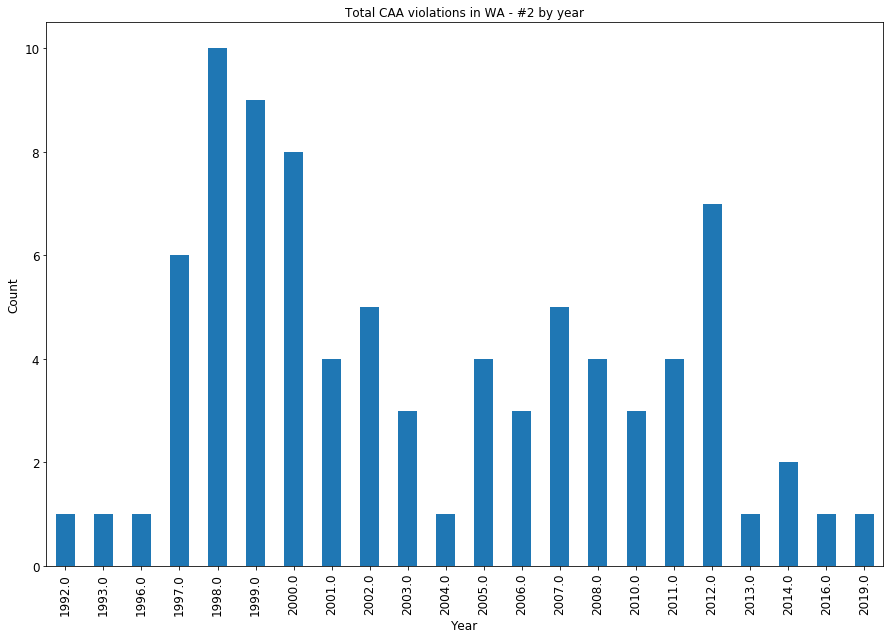

In [67]:
chart_title = "Total CAA violations"

show_plot( my_cd_icis, 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_YEAR', 
          my_state + ' - #' + str( my_cd ), '%m-%d-%Y', chart_title )

## Plot the number of violations by year, using the entire state.
Since the number of violations in a single CD may be small, it can be more
interesting to look at the entire state.

                  HPV_DAYZERO_YEAR
HPV_DAYZERO_YEAR                  
1992.0                           2
1993.0                           3
1994.0                           7
1995.0                           4
1996.0                          10
1997.0                          55
1998.0                          78
1999.0                          49
2000.0                          57
2001.0                          22
2002.0                          25
2003.0                          31
2004.0                          24
2005.0                          25
2006.0                          21
2007.0                          24
2008.0                          24
2009.0                          15
2010.0                          11
2011.0                          15
2012.0                          16
2013.0                           5
2014.0                           4
2015.0                           8
2016.0                          10
2017.0                           4
2018.0              

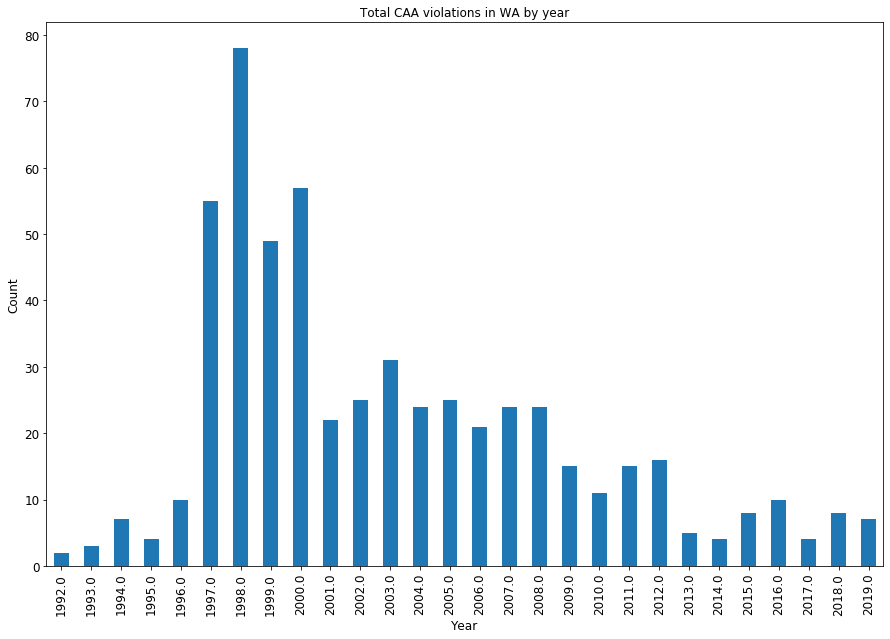

In [68]:
chart_title = "Total CAA violations"

show_plot( icis_data, 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_YEAR', \
          my_state, '%m-%d-%Y', chart_title )